In [2]:

import os
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [3]:
# === PyTorch: Set device ===
# Load dataset
df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Drop columns with all NaNs or unnamed indices
df = df.dropna(axis=1, how='all')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Replace inf/-inf with NaN, then fill NaNs with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Encode labels: 1 for attack, 0 for normal
df['Label'] = df['Label'].apply(lambda x: 0 if 'BENIGN' in x else 1)

# Drop non-numeric/categorical columns if any
non_numerics = df.select_dtypes(include=['object']).columns
df = df.drop(non_numerics.difference(['Label']), axis=1)

# Separate features and labels
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Feature dimension:", X_train.shape[1])


Training samples: 180596
Feature dimension: 78


In [4]:
# Create PyTorch datasets
# Extract attack samples (label = 1)
X_attack = X_train[y_train == 1]

print(f"Attack sample count: {X_attack.shape[0]}")
print(f"Feature dimension: {X_attack.shape[1]}")


Attack sample count: 102283
Feature dimension: 78


In [5]:
# === MobileGAN: A PyTorch Implementation for Generating Synthetic Attack Data ===
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 64
feature_dim = 78
batch_size = 128
lr = 0.0001
epochs = 100

# ===== Generator =====
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, feature_dim),
        )

    def forward(self, z):
        return self.model(z)

# ===== Discriminator =====
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ===== Load and prepare attack data =====
X_attack_tensor = torch.tensor(X_attack, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_attack_tensor), batch_size=batch_size, shuffle=True)

# ===== Initialize models and training utils =====
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# ===== Training Loop =====
for epoch in range(epochs):
    for real_batch, in train_loader:
        real_batch = real_batch.to(device)
        batch_size_curr = real_batch.size(0)

        # Real and fake label smoothing
        real_labels = torch.ones(batch_size_curr, 1).uniform_(0.9, 1.0).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).uniform_(0.0, 0.1).to(device)

        # === Train Discriminator ===
        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_data = generator(z)

        d_real = discriminator(real_batch)
        d_fake = discriminator(fake_data.detach())

        loss_real = criterion(d_real, real_labels)
        loss_fake = criterion(d_fake, fake_labels)
        d_loss = loss_real + loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
        optimizer_D.step()

        # === Train Generator ===
        z = torch.randn(batch_size_curr, latent_dim).to(device)
        fake_data = generator(z)
        g_loss = criterion(discriminator(fake_data), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# ===== Save the trained generator =====
torch.save(generator.state_dict(), "mobilegan_generator_stable.pth")

# ===== Function to generate synthetic samples =====
def generate_synthetic_samples(generator, num_samples=1000):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        synthetic_data = generator(z)
    return synthetic_data.cpu().numpy()

# ===== Generate and Save Synthetic Attack Data =====
synthetic_attacks = generate_synthetic_samples(generator, num_samples=1000)
df_synthetic = pd.DataFrame(synthetic_attacks)
df_synthetic.to_csv("synthetic_attacks.csv", index=False)
print(" Synthetic attack data saved as 'synthetic_attacks.csv'")


Epoch [1/100] | D Loss: 1.1520 | G Loss: 1.0355
Epoch [2/100] | D Loss: 1.2305 | G Loss: 0.8701
Epoch [3/100] | D Loss: 1.1473 | G Loss: 0.8455
Epoch [4/100] | D Loss: 1.2799 | G Loss: 1.2312
Epoch [5/100] | D Loss: 1.2542 | G Loss: 0.9263
Epoch [6/100] | D Loss: 1.1649 | G Loss: 0.9657
Epoch [7/100] | D Loss: 1.2217 | G Loss: 0.8947
Epoch [8/100] | D Loss: 1.1157 | G Loss: 1.3657
Epoch [9/100] | D Loss: 1.1623 | G Loss: 1.3146
Epoch [10/100] | D Loss: 1.0524 | G Loss: 1.0014
Epoch [11/100] | D Loss: 1.0661 | G Loss: 1.0420
Epoch [12/100] | D Loss: 0.9575 | G Loss: 1.1310
Epoch [13/100] | D Loss: 0.9578 | G Loss: 1.0727
Epoch [14/100] | D Loss: 0.9340 | G Loss: 2.7024
Epoch [15/100] | D Loss: 1.1826 | G Loss: 1.3510
Epoch [16/100] | D Loss: 1.0000 | G Loss: 1.2296
Epoch [17/100] | D Loss: 0.9488 | G Loss: 2.7022
Epoch [18/100] | D Loss: 1.0148 | G Loss: 2.5728
Epoch [19/100] | D Loss: 1.0110 | G Loss: 1.4240
Epoch [20/100] | D Loss: 0.9308 | G Loss: 1.1295
Epoch [21/100] | D Loss: 0.89

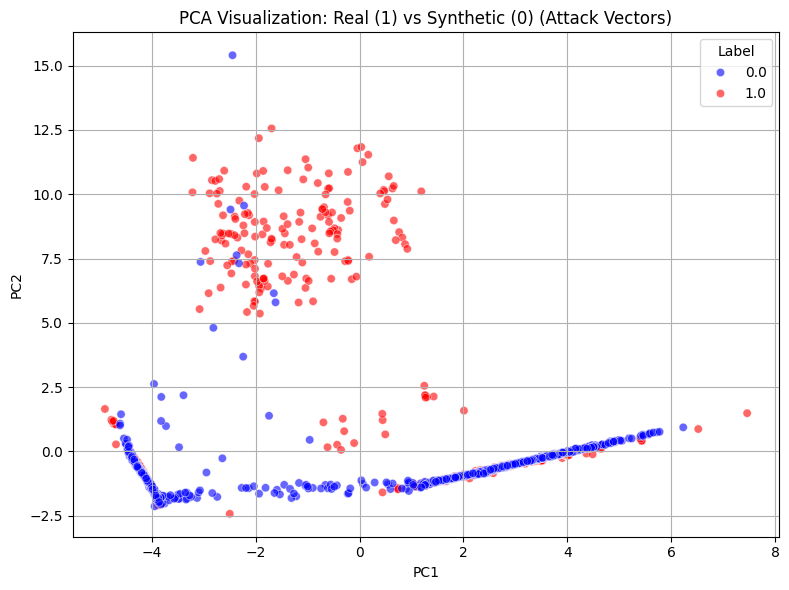

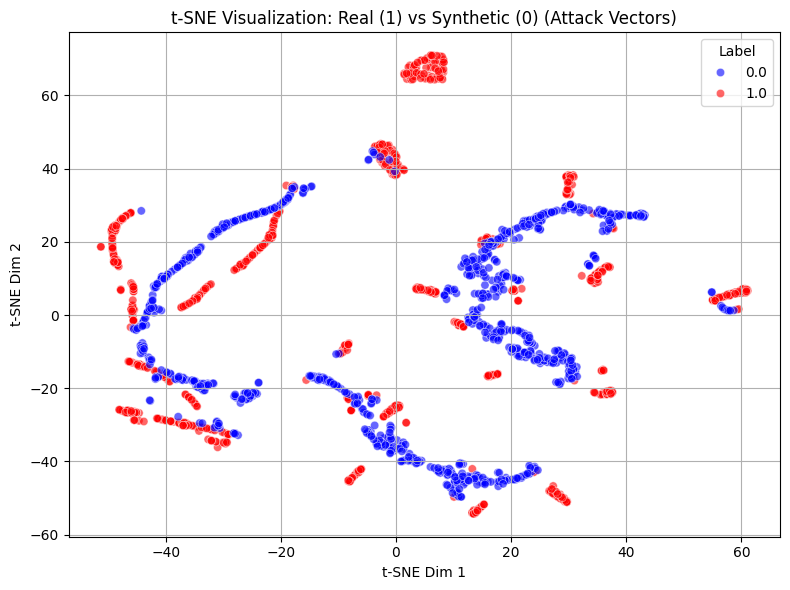

Epoch 1/10, Loss: 8.8697
Epoch 2/10, Loss: 8.7058
Epoch 3/10, Loss: 8.5962
Epoch 4/10, Loss: 8.4722
Epoch 5/10, Loss: 8.3751
Epoch 6/10, Loss: 8.3455
Epoch 7/10, Loss: 8.3177
Epoch 8/10, Loss: 8.2752
Epoch 9/10, Loss: 8.2262
Epoch 10/10, Loss: 8.2347

📊 Discriminator Evaluation Report:
              precision    recall  f1-score   support

         0.0     0.5702    0.6500    0.6075       200
         1.0     0.5930    0.5100    0.5484       200

    accuracy                         0.5800       400
   macro avg     0.5816    0.5800    0.5779       400
weighted avg     0.5816    0.5800    0.5779       400

ROC-AUC Score: 0.6052

Confusion Matrix:
[[130  70]
 [ 98 102]]


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
real_attacks = X_attack
synthetic_attacks = pd.read_csv("synthetic_attacks.csv").values

# Balance real and synthetic samples
min_len = min(len(real_attacks), len(synthetic_attacks))
real_balanced = real_attacks[:min_len]
synthetic_balanced = synthetic_attacks[:min_len]

# Assign labels
real_labels = np.ones((min_len, 1))
synthetic_labels = np.zeros((min_len, 1))

# Combine for evaluation
X_eval = np.vstack([real_balanced, synthetic_balanced])
y_eval = np.vstack([real_labels, synthetic_labels]).flatten()

# === PCA + t-SNE Visualization ===
def plot_visualizations(X_data, y_data, title_suffix=""):
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_data, palette=["blue", "red"], alpha=0.6)
    plt.title(f"PCA Visualization: Real (1) vs Synthetic (0) {title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Label")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(X_data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_data, palette=["blue", "red"], alpha=0.6)
    plt.title(f"t-SNE Visualization: Real (1) vs Synthetic (0) {title_suffix}")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend(title="Label")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_visualizations(X_eval, y_eval, "(Attack Vectors)")

# Stratified train-test split
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
    X_eval, y_eval, test_size=0.2, random_state=42, stratify=y_eval
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_eval, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_eval, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_eval, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_eval, dtype=torch.float32).view(-1, 1)

# DataLoader
eval_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_dim=78):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
disc_eval = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(disc_eval.parameters(), lr=0.0001)

# Train discriminator
epochs = 10
for epoch in range(epochs):
    disc_eval.train()
    epoch_loss = 0
    for xb, yb in eval_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = disc_eval(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluate
disc_eval.eval()
with torch.no_grad():
    preds = disc_eval(X_test_tensor.to(device)).cpu().numpy().flatten()
    preds_binary = (preds >= 0.5).astype(int)

# Print metrics
print("\n📊 Discriminator Evaluation Report:")
print(classification_report(y_test_eval, preds_binary, digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_test_eval, preds):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_eval, preds_binary))


In [7]:
import numpy as np
import pandas as pd

# 1. Get benign samples
X_benign = X_train[y_train == 0]
y_benign = np.zeros((X_benign.shape[0],))  # Label: 0

# 2. Use real attacks
X_real_attack = X_attack
y_real_attack = np.ones((X_real_attack.shape[0],))  # Label: 1

# 3. Load synthetic attacks
X_synth_attack = pd.read_csv("synthetic_attacks.csv").values
y_synth_attack = np.ones((X_synth_attack.shape[0],))  # Label: 1

# 4. Combine all
X_ids = np.vstack([X_benign, X_real_attack, X_synth_attack])
y_ids = np.hstack([y_benign, y_real_attack, y_synth_attack])

print(f"Total IDS dataset size: {X_ids.shape}")
print(f"Class distribution: Normal = {(y_ids==0).sum()}, Attack = {(y_ids==1).sum()}")


Total IDS dataset size: (181596, 78)
Class distribution: Normal = 78313, Attack = 103283


In [8]:
X_train_ids, X_test_ids, y_train_ids, y_test_ids = train_test_split(
    X_ids, y_ids, test_size=0.2, random_state=42, stratify=y_ids
)

# Reshape for 1D CNN: (batch, channels=1, features)
X_train_tensor = torch.tensor(X_train_ids, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_ids, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_ids, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_ids, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

# Define 1D CNN model
class CNN_IDS(nn.Module):
    def __init__(self, input_len=78):
        super(CNN_IDS, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_IDS().to(device)

In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/10, Loss: 43.3598
Epoch 2/10, Loss: 6.9275
Epoch 3/10, Loss: 6.6352
Epoch 4/10, Loss: 4.3693
Epoch 5/10, Loss: 3.4866
Epoch 6/10, Loss: 3.8144
Epoch 7/10, Loss: 3.4911
Epoch 8/10, Loss: 3.2111
Epoch 9/10, Loss: 2.8504
Epoch 10/10, Loss: 2.8149


In [11]:
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = model(xb).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        all_preds.extend(preds)
        all_probs.extend(probs)

# Metrics
print("\n📊 IDS Classifier Evaluation Report:")
print(classification_report(y_test_ids, all_preds, digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_test_ids, all_probs):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_ids, all_preds))



📊 IDS Classifier Evaluation Report:
              precision    recall  f1-score   support

         0.0     0.9996    0.9980    0.9988     15663
         1.0     0.9985    0.9997    0.9991     20657

    accuracy                         0.9989     36320
   macro avg     0.9990    0.9988    0.9989     36320
weighted avg     0.9989    0.9989    0.9989     36320

ROC-AUC Score: 1.0000
Confusion Matrix:
[[15631    32]
 [    7 20650]]


In [10]:
# Export TorchScript model
example_input = torch.rand(1, 1, 78).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("ids_cnn_edgegensec.pt")
print("✅ TorchScript model saved as 'ids_cnn_edgegensec.pt'")


✅ TorchScript model saved as 'ids_cnn_edgegensec.pt'


c:\Users\aadip\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\jit\_trace.py:1304: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1 / 1 (100.0%)
Greatest absolute difference: 1.4328997849588632e-05 at index (0, 0) (up to 1e-05 allowed)
Greatest relative difference: 0.931435822037693 at index (0, 0) (up to 1e-05 allowed)
  _check_trace(
